In [1]:
import os
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  #忽略烦人的警告
tf.logging.set_verbosity(tf.logging.ERROR)   #忽略烦人的警告
print(tf.__version__)
import numpy as np
from sklearn.decomposition import PCA

import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split
import pickle   #对象存储用


from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
rfr = RandomForestClassifier(n_estimators=200, criterion='entropy')

1.13.1


In [2]:
def read_data():
    """
        读取数据，
        return
            train_dataset : 训练数据 
            test_dataset  ：测试数据
    """
    input_file_dir = "."
    train_file_name = "kddcup.data_10_percent"
    test_file_name = "corrected.txt"
    header_file_name = "header.txt"
    
    train_files = os.path.join(input_file_dir, train_file_name)
    test_files = os.path.join(input_file_dir, test_file_name)
    header_files = os.path.join(input_file_dir, header_file_name)
    
    with open(header_files, 'r') as f:
        header = f.readline().strip().split(',')
    train_dataset = pd.read_csv(train_files)
    test_dataset = pd.read_csv(test_files)
    train_dataset.columns = header
    test_dataset.columns = header
    dataset = train_dataset.append(test_dataset)
    return dataset
  
def filter_labels(dataset):
    dataset['labels'] = dataset['labels'].apply(labels_map)
    return dataset

def labels_map(label):
    if(type(label) == int):      #已是数字，无需处理
        return label
    label = label.split('.')[0]
    
    DOS = ['apache2', 'back', 'land', 'mailbomb', 'neptune', 'pod', 
                  'processtable', 'smurf', 'teardrop', 'udpstorm'] #DOS 10个
    PROBE = ['ipsweep', 'mscan', 'nmap', 'portsweep', 'saint', 'satan'] #PROBE
    U2R = ['buffer_overflow', 'httptunnel', 'loadmodule', 'perl', 'ps', 'rootkit', 'sqlattack', 'xterm'] #U2R
    R2L = ['ftp_write', 'guess_passwd', 'imap', 'multihop', 'named', 'phf', 
           'sendmail', 'snmpgetattack', 'snmpguess', 'spy', 'warezclient', 
           'warezmaster', 'worm', 'xlock', 'xsnoop']#R2L
    
    if label == 'normal':
        return 0
    if label in DOS:
        return 1
    if label in PROBE:
        return 2
    if label in U2R:
        return 3
    if label in R2L:
        return 4
    return -1

def split_valid_from_train(train_dataset, valid_size):
    # Method 1
    train_dataset, valid_dataset, _, _ = train_test_split(train_dataset, train_dataset['labels'], test_size=valid_size, random_state=None)
    # pandas中先重置index再打乱train. 否则只会调整各个行的顺序，而不会改变pandas的index
    # 重置
    train_dataset = train_dataset.reset_index(drop=True)
    # 打乱
    indexMask = np.arange(len(train_dataset))
    for i in range(10):
        np.random.shuffle(indexMask)
    train_dataset = train_dataset.iloc[indexMask]

    return train_dataset, valid_dataset

def labels_separate(dataset):
    y_ = dataset['labels'].values
    temp = dataset
    temp.drop('labels', axis=1, inplace=True)
    x_ = temp.values
    return x_, y_

def one_hot_process(dataset):
    # 独热编码 protocol_type
    protocal_type_dummies = pd.get_dummies(dataset['protocol_type'], prefix='protocol_type')
    dataset = pd.concat([dataset, protocal_type_dummies], axis=1)
    dataset = dataset.drop(['protocol_type'], axis=1)
    # 独热编码 flag
    flag_dummies = pd.get_dummies(dataset['flag'], prefix='flag')
    dataset = pd.concat([dataset, flag_dummies], axis=1)
    dataset = dataset.drop(['flag'], axis=1)
    # 独热编码 service     （现阶段第三列数据对接有问题，暂时直接除掉这一条数据）
    service_dummies = pd.get_dummies(dataset['service'], prefix='service')
    dataset = pd.concat([dataset, service_dummies], axis=1)
    dataset = dataset.drop(['service'], axis=1)
    return dataset
#归一化整个数据集，注意要存储归一化的参数x_avg,x_max,x_min以便后面真实环境预处理需要
def normalization(dataset):
    epsilon = 0.0001   #防止除数为0
    dataset = dataset.astype('float')
    target_features = [
        'duration', 'src_bytes', 'dst_bytes','wrong_fragment',
        'urgent', 'hot','num_failed_logins', 'num_compromised', 
        'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 
        'num_outbound_cmds', 'count', 'srv_count', 'dst_host_count', 'dst_host_srv_count'
    ]
    norm_params = pd.DataFrame(np.zeros([3, len(target_features)]), columns=target_features)  #存储归一化参数
    
    for feature in dataset.columns.values.tolist():    #对列（特征名）进行遍历
        if feature in target_features:
            x = dataset[feature]
            x_avg = dataset[feature].mean()
            x_max = np.max(dataset[feature])
            x_min = np.min(dataset[feature])

            norm_params[feature] = [x_avg, x_max, x_min]
            dataset[feature] = (x - x_min) / (x_max - x_min + epsilon)
            #dataset = dataset.drop([feature], axis=1)
    return dataset,norm_params
    
def combine_dataset(trainDF, testDF):
    all = pd.concat([trainDF, testDF], axis=0)
    return all, (trainDF.shape[0], testDF.shape[0])

def separate_dataset(comb, num_comb):  
    train_dataset_size , test_dataset_size = num_comb
    trainDF = comb.iloc[:train_dataset_size]
    testDF = comb.iloc[train_dataset_size: (train_dataset_size + test_dataset_size)]
    return trainDF, testDF

   
def data_process_full(trainDF, testDF):
    all, num_comb = combine_dataset(trainDF, testDF)
    all = one_hot_process(all)
    all,norm_params = normalization(all)
    trainDF,testDF = separate_dataset(all, num_comb)
    return trainDF,testDF,norm_params

In [3]:
dataset = read_data()

dataset = filter_labels(dataset)


In [4]:
print(dataset.loc[:,'labels'].value_counts())

1    621311
0    157869
4     17315
2      8273
3       280
Name: labels, dtype: int64


In [5]:
normal_df = dataset.loc[dataset['labels'] == 0]
normal_df = normal_df.sample(n=80000,random_state=1, replace=False)
df_normal_train, df_normal_test = split_valid_from_train(normal_df, 0.2)

DOS_df = dataset.loc[dataset['labels'] == 1]
DOS_df = DOS_df.sample(n=100000,random_state=1, replace=False)
df_DOS_train, df_DOS_test = split_valid_from_train(DOS_df, 0.2)


PROBE_df = dataset.loc[dataset['labels'] == 2]
PROBE_df = PROBE_df.sample(n=5000,random_state=1, replace=True)
df_PROBE_train, df_PROBE_test = split_valid_from_train(PROBE_df, 0.2)


U2R_df = dataset.loc[dataset['labels'] == 3]
U2R_df = U2R_df.sample(n=1000,random_state=1, replace=True)
df_U2R_train, df_U2R_test = split_valid_from_train(U2R_df, 0.2)


R2L_df = dataset.loc[dataset['labels'] == 4]
R2L_df = R2L_df.sample(n=1000,random_state=1, replace=True)
df_R2L_train, df_R2L_test = split_valid_from_train(R2L_df, 0.2)


In [6]:
#整合
df_train = df_normal_train.append([df_DOS_train, df_PROBE_train, df_U2R_train, df_R2L_train])
df_test = df_normal_test.append([df_DOS_test, df_PROBE_test, df_U2R_test, df_R2L_test])

In [7]:
#独热编码和正则化
df_train, df_test, norm_params = data_process_full(
    df_train, df_test
)

In [8]:
print(df_train.shape)
print(df_train.loc[:,'labels'].value_counts())

(149600, 119)
1.0    80000
0.0    64000
2.0     4000
4.0      800
3.0      800
Name: labels, dtype: int64


In [9]:
#分离标签
df_train_X, df_train_y = labels_separate(df_train)
df_test_X, df_test_y = labels_separate(df_test)

In [10]:
df_train_y = df_train_y.astype('int')
df_test_y = df_test_y.astype('int')

In [11]:
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import classification_report
from tensorflow.keras.layers import BatchNormalization

import matplotlib.pyplot as plt
import matplotlib
#超参数设置
learning_rate = 0.001
epochs = 10
batch_size = 256
activation = tf.nn.relu         #非输出层下的激活函数

In [12]:
#用于记录训练中每个batch的loss
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.train_losses_per_batch = []
        self.train_losses_per_epoch = []
        self.valid_losses_per_epoch = []
        
    def on_batch_end(self, batch, logs={}):
        self.train_losses_per_batch.append(logs.get('loss'))
        
    def on_epoch_end(self, epoch, logs={}):
        self.train_losses_per_epoch.append(logs.get('loss'))
        self.valid_losses_per_epoch.append(logs.get('val_loss')*4)   #验证集由于只有1/4的训练集大小所以损失要乘以4
#用于记录训练中每个epoch的召回率，精确度以及f1 score
class Metrics(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.val_f1s = []
        self.val_recalls = []
        self.val_precisions = []
        return

    def on_epoch_end(self, epoch, logs={}):
        predictions = self.model.predict(df_test_X)
        val_predict = np.argmax(predictions, axis=1)     #把独热编码转化成数字
        val_targ = df_test_y
        _val_recall = recall_score(val_targ, val_predict, average='macro')
        _val_precision = precision_score(val_targ, val_predict, average='macro')
        _val_f1 = f1_score(val_targ, val_predict, average='macro')
        self.val_f1s.append(_val_f1)
        self.val_recalls.append(_val_recall)
        self.val_precisions.append(_val_precision)
        return       
#回调：模型跑完epoch后选取最好的epoch模型保存，选取标准为验证集损失最小的那一个
checkpoint = keras.callbacks.ModelCheckpoint(      
    "./KDD_model.h5",
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min',
    period=1
)
def simple_model():
    model = keras.Sequential([
        keras.layers.Dense(df_train_X.shape[1], activation=activation, input_shape=(df_train_X.shape[1],)),
        BatchNormalization(),
        keras.layers.Dense(64, activation=activation),
        BatchNormalization(),
        keras.layers.Dense(32, activation=activation),
        BatchNormalization(),
        keras.layers.Dense(16, activation=activation),
        BatchNormalization(),
        keras.layers.Dense(5,activation=tf.nn.softmax)
    ])
    model.compile(optimizer =tf.train.AdamOptimizer(learning_rate=learning_rate),
        loss="sparse_categorical_crossentropy",
        metrics=['accuracy']
    )
    model.summary()
    history = LossHistory()
    metrics = Metrics()
    model.fit(
        df_train_X,df_train_y,
        validation_data=[df_test_X, df_test_y],
        batch_size=batch_size,epochs=epochs,
        callbacks=[history, metrics, checkpoint]
    )   
    return model,history,metrics
model,history,metrics = simple_model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 118)               14042     
_________________________________________________________________
batch_normalization_v1 (Batc (None, 118)               472       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                7616      
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 64)                256       
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
batch_normalization_v1_2 (Ba (None, 32)                128       
_________________________________________________________________
dense_3 (Dense)              (None, 16)                528       
__________

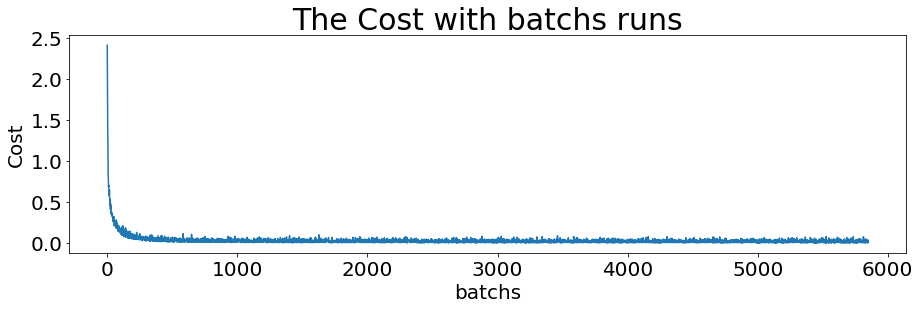

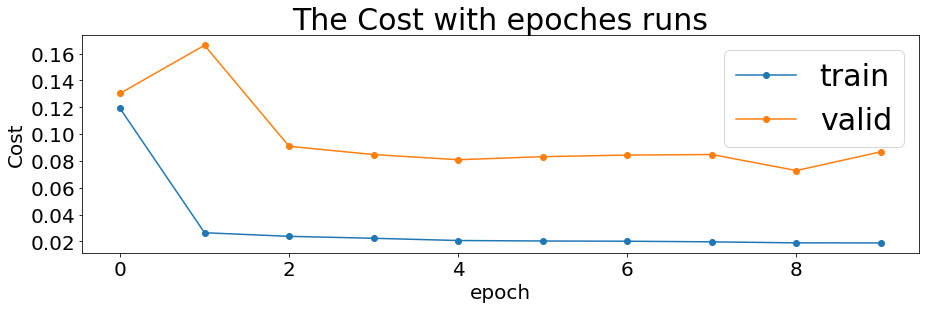

In [13]:
#绘制训练集在batch下的损失变化
plt.title('The Cost with batchs runs',fontsize=30)
plt.xlabel('batchs',fontsize=20)
plt.ylabel('Cost',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.plot(history.train_losses_per_batch)
plt.gcf().set_size_inches(15,4)
plt.show()
#绘制训练集与验证集在epoch下的损失比较
plt.title('The Cost with epoches runs',fontsize=30)
plt.xlabel('epoch',fontsize=20)
plt.ylabel('Cost',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.plot(history.train_losses_per_epoch, '-o', label='train')
plt.plot(history.valid_losses_per_epoch, '-o', label='valid')
plt.legend(fontsize=30,loc='upper right')
plt.gcf().set_size_inches(15,4)
plt.show()

In [14]:
#选取验证集准确率最高的模型
model = keras.models.load_model('./KDD_model.h5') 
model.compile(optimizer =tf.train.AdamOptimizer(learning_rate=learning_rate),
    loss="sparse_categorical_crossentropy",
    metrics=['accuracy']
)
#测试集的正确率
def use_evaluate_test():
    test_loss,test_acc = model.evaluate(df_test_X,df_test_y)
    print('Test accuracy:', test_acc)
    return 
use_evaluate_test()

37400/37400 [==============================] - 2s 58us/sample - loss: 0.0182 - acc: 0.9949
Test accuracy: 0.9948931


In [16]:
labelList = ["normal", "DoS", "PROBE", "U2R", "R2L"]

In [17]:
predictions = model.predict(df_test_X)
print(classification_report(df_test_y, np.argmax(predictions, axis=1) , target_names=labelList))

              precision    recall  f1-score   support

      normal       0.99      1.00      0.99     16000
         DoS       1.00      1.00      1.00     20000
       PROBE       0.98      0.99      0.99      1000
         U2R       0.97      0.93      0.95       200
         R2L       0.87      0.35      0.50       200

   micro avg       0.99      0.99      0.99     37400
   macro avg       0.96      0.86      0.89     37400
weighted avg       0.99      0.99      0.99     37400



In [19]:
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier


score = 0
for i in range(20):
    clf = DecisionTreeClassifier(criterion='entropy', min_samples_leaf=3)
    clf.fit(df_train_X, df_train_y)
    y_pred = clf.predict(df_test_X)
    result = clf.score(df_test_X, df_test_y)
    if(score < result):
        score = result
        print(score)
        print(classification_report(df_test_y, y_pred, target_names=labelList))
        

0.9966310160427807
              precision    recall  f1-score   support

      normal       0.99      1.00      1.00     16000
         DoS       1.00      1.00      1.00     20000
       PROBE       0.99      0.99      0.99      1000
         U2R       0.98      0.98      0.98       200
         R2L       0.97      0.57      0.72       200

   micro avg       1.00      1.00      1.00     37400
   macro avg       0.99      0.91      0.94     37400
weighted avg       1.00      1.00      1.00     37400

0.9966577540106952
              precision    recall  f1-score   support

      normal       0.99      1.00      1.00     16000
         DoS       1.00      1.00      1.00     20000
       PROBE       0.99      0.99      0.99      1000
         U2R       0.97      0.99      0.98       200
         R2L       0.98      0.57      0.73       200

   micro avg       1.00      1.00      1.00     37400
   macro avg       0.99      0.91      0.94     37400
weighted avg       1.00      1.00      